In [1]:
%reload_ext autoreload
%autoreload 2

# 1. Downlad and Load AlphaDeep models

In [2]:
import alphadeep.pretrained_models

ms2_model, rt_model, ccs_model = alphadeep.pretrained_models.load_models()

In [3]:
ms2_model.get_parameter_num()

5351690

In [4]:
rt_model.get_parameter_num()

708224

In [5]:
ccs_model.get_parameter_num()

713452

# 2. Test RT/CCS/MSMS

In [6]:
from alphadeep.model.rt import evaluate_linear_regression, evaluate_linear_regression_plot
import os
import wget
import zipfile
result_zip = 'sandbox/test_result.zip'
test_dir = 'sandbox/test_files'
if not os.path.exists(result_zip):
    url='http://ftp.pride.ebi.ac.uk/pride/data/archive/2021/01/PXD019086/Results_HeLa_trypsin.zip'
    wget.download(url, result_zip)
    with zipfile.ZipFile(result_zip, 'r') as zip_ref:
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        zip_ref.extractall(test_dir)

In [7]:
from alphadeep.psm_reader.psm_reader import psm_reader_provider
import alphadeep.psm_reader.maxquant_reader # register mq reader to psm_reader_provider

mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.load(test_dir+'/evidence.txt')

/Users/zengwenfeng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (61) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## CCS prediction is very good

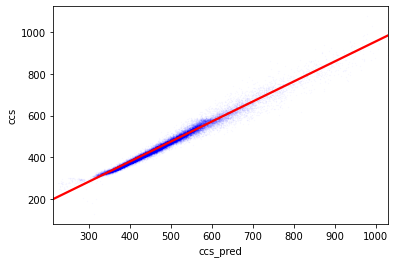

,R_square,R,slope,intercept,n_sample
0,0.979,0.989444,0.9618,-5.8678,42253.0


In [8]:
psm_df = mq_reader.psm_df.groupby(['sequence','mods','mod_sites','nAA','charge'])['ccs'].median().reset_index()
predict_df = ccs_model.predict(psm_df)
evaluate_linear_regression_plot(predict_df, x='ccs_pred',y='ccs')
evaluate_linear_regression(predict_df, x='ccs_pred',y='ccs')

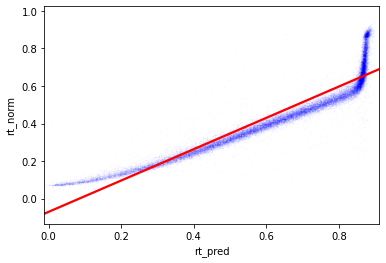

,R_square,R,slope,intercept,n_sample
0,0.875,0.935414,0.8334,-0.07,36579.0


In [9]:
psm_df = mq_reader.psm_df.groupby(['sequence','mods','mod_sites','nAA'])['rt_norm'].median().reset_index()
predict_df = rt_model.predict(psm_df)

evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

In [10]:
import numpy as np
import pandas as pd
n_train = 5000

from alphadeep.rescore.feature_extractor import uniform_sampling

In [11]:
n_train = 5000
train_df, test_df = uniform_sampling(psm_df, n_train=n_train, return_test_df=True)

## Using re-calibration for better RT prediction

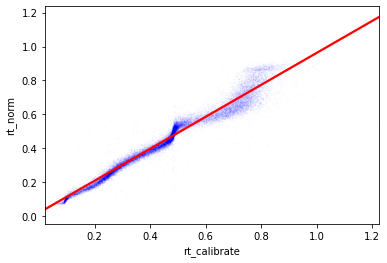

,R_square,R,slope,intercept,n_sample
0,0.949,0.974166,0.9435,0.0192,31781.0


In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
gpr = GaussianProcessRegressor().fit(
    train_df.rt_pred.values.reshape((-1, 1)),
    train_df.rt_norm.values
)
test_df['rt_calibrate'] = gpr.predict(
    test_df.rt_pred.values.reshape((-1,1))
)

evaluate_linear_regression_plot(test_df, x='rt_calibrate',y='rt_norm')
evaluate_linear_regression(test_df, x='rt_calibrate',y='rt_norm')

In [13]:
predict_df

,sequence,mods,mod_sites,nAA,rt_norm,rt_pred
0,AAAAELLLNLLFFEK,,,15,0.881272,0.872408
1,AAAAIIDSTTETNKGDDYR,,,19,0.203951,0.353239
2,AAAANLNYIR,,,10,0.222895,0.367090
3,AAAAPTISQSISTLTSGMR,Oxidation@M,18,19,0.437990,0.642911
4,AAAAPTLSPPADTTITTLYIGNLGPSGAQQVTEK,,,34,0.642849,0.864315
...,...,...,...,...,...,...
36574,YYVHLETR,,,8,0.173454,0.290798
36575,YYVHVDGER,,,9,0.143916,0.202127
36576,YYYAIYEIVVR,,,11,0.569403,0.808042
36577,YYYDHSK,,,7,0.083326,0.076875


## Or using transfer learning for better RT prediction

In [14]:
rt_model.train(train_df, epoch=20, verbose=True, verbose_each_epoch=False)

[Training] Epoch=1, Mean Loss=0.049184139131715425
[Training] Epoch=2, Mean Loss=0.02264858051938446
[Training] Epoch=3, Mean Loss=0.017196476018350376
[Training] Epoch=4, Mean Loss=0.01593545554695945
[Training] Epoch=5, Mean Loss=0.015020982533889381
[Training] Epoch=6, Mean Loss=0.015453873312492905
[Training] Epoch=7, Mean Loss=0.012028253747542439
[Training] Epoch=8, Mean Loss=0.012223450050346162
[Training] Epoch=9, Mean Loss=0.012747466429381779
[Training] Epoch=10, Mean Loss=0.012184595027448316
[Training] Epoch=11, Mean Loss=0.012787195155397058
[Training] Epoch=12, Mean Loss=0.011940786137098544
[Training] Epoch=13, Mean Loss=0.013476035128788729
[Training] Epoch=14, Mean Loss=0.01400746762948601
[Training] Epoch=15, Mean Loss=0.011295403439649626
[Training] Epoch=16, Mean Loss=0.010561926541604885
[Training] Epoch=17, Mean Loss=0.010782816024546168
[Training] Epoch=18, Mean Loss=0.01164174704861484
[Training] Epoch=19, Mean Loss=0.01195874239171022
[Training] Epoch=20, Mean 

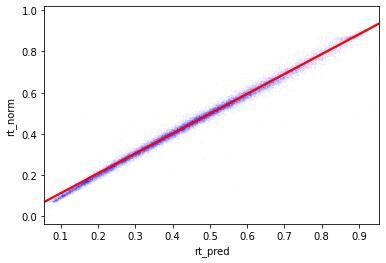

,R_square,R,slope,intercept,n_sample
0,0.977,0.988433,0.9638,0.0161,31781.0


In [15]:
predict_df = rt_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

# 3. Predicted spectral library

In [23]:
from alphadeep.spec_lib.predict_lib import PredictLib
predlib = PredictLib(
    ms2_model.charged_frag_types, ms2_model=ms2_model, 
    rt_model=rt_model, ccs_model=ccs_model
)
predlib.precursor_df = mq_reader.psm_df
predlib.predict_rt_ccs()

100%|██████████| 41/41 [01:48<00:00,  2.65s/it]


In [19]:
predlib.precursor_df['instrument'] = 'timsTOF'
predlib.precursor_df['nce'] = 30 # always set as 30 for timsTOF
predlib.load_fragment_intensity_df()

100%|██████████| 41/41 [05:26<00:00,  7.95s/it]


In [28]:
predlib.precursor_df

,sequence,charge,rt,rt_norm,ccs,mobility,spec_idx,raw_name,score,proteins,...,nAA,mods,mod_sites,rt_pred,irt_pred,ccs_pred,precursor_mz,mobility_pred,instrument,nce
0,AAAAELLLNLLFFEK,2,105.630,0.880397,443.065744,1.097107,13092,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,78.157,G5EG62,...,15,,,0.892073,154.699869,472.419373,831.976898,1.169774,timsTOF,30
1,AAAAELLLNLLFFEK,2,105.840,0.882147,444.310833,1.100190,26278,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,47.570,G5EG62,...,15,,,0.892073,154.699869,472.419373,831.976898,1.169774,timsTOF,30
2,AAAAIIDSTTETNKGDDYR,2,24.470,0.203951,479.686910,1.189493,33028,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,69.201,G5EC97,...,19,,,0.205332,8.664434,508.577606,1006.481990,1.261117,timsTOF,30
3,AAAANLNYIR,2,26.743,0.222895,337.093583,0.830968,7191,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,51.430,P53588,...,10,,,0.222575,12.331135,355.560303,538.795997,0.876478,timsTOF,30
4,AAAAPTISQSISTLTSGMR,2,52.534,0.437856,456.322809,1.131009,26721,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,70.598,O02109,...,19,Oxidation@M,18,0.419210,54.145546,476.474304,939.983114,1.180938,timsTOF,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141258,YYYFSPLYR,2,53.575,0.446533,371.606865,0.917830,12713,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,34.931,K8ESK7;H9G321;A5Z2W3,...,9,,,0.453552,61.448268,393.405426,636.308406,0.971656,timsTOF,30
141259,YYYFSPLYR,2,53.810,0.448491,370.352338,0.914732,10781,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,72.492,K8ESK7;H9G321;A5Z2W3,...,9,,,0.453552,61.448268,393.405426,636.308406,0.971656,timsTOF,30
141260,YYYFSPLYR,2,54.022,0.450258,369.097543,0.911633,5581,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,49.325,K8ESK7;H9G321;A5Z2W3,...,9,,,0.453552,61.448268,393.405426,636.308406,0.971656,timsTOF,30
141261,YYYFSPLYR,2,54.000,0.450075,369.097189,0.911633,3877,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,130.000,K8ESK7;H9G321;A5Z2W3,...,9,,,0.453552,61.448268,393.405396,636.308406,0.971656,timsTOF,30


In [21]:
predlib.fragment_mz_df

,b_z1,b_z2,y_z1,y_z2,b_modloss_z1,b_modloss_z2,y_modloss_z1,y_modloss_z2
0,72.044390,36.525833,757.410383,379.208829,0.0,0.0,0.0,0.0
1,219.112804,110.060040,610.341969,305.674622,0.0,0.0,0.0,0.0
2,332.196868,166.602072,497.257905,249.132590,0.0,0.0,0.0,0.0
3,469.255780,235.131528,360.198993,180.603134,0.0,0.0,0.0,0.0
4,540.292893,270.650085,289.161879,145.084578,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2227056,3972.276515,1986.641896,561.314357,281.160817,0.0,0.0,0.0,0.0
2227057,4119.344929,2060.176103,414.245943,207.626610,0.0,0.0,0.0,0.0
2227058,4190.382043,2095.694660,343.208829,172.108053,0.0,0.0,0.0,0.0
2227059,4261.419157,2131.213216,272.171716,136.589496,0.0,0.0,0.0,0.0


In [22]:
predlib.fragment_intensity_df

,b_z1,b_z2,y_z1,y_z2,b_modloss_z1,b_modloss_z2,y_modloss_z1,y_modloss_z2
0,0.000000,0.0,410.761535,0.0,0.0,0.0,0.0,0.0
1,154.149374,0.0,4742.088020,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,9994.363785,0.0,0.0,0.0,0.0,0.0
3,244.245380,0.0,8505.758047,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,1230.560169,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2227056,0.000000,0.0,287.498422,0.0,0.0,0.0,0.0,0.0
2227057,0.000000,0.0,164.283086,0.0,0.0,0.0,0.0,0.0
2227058,0.000000,0.0,298.556034,0.0,0.0,0.0,0.0,0.0
2227059,0.000000,0.0,305.138510,0.0,0.0,0.0,0.0,0.0
